## Lead Score Analysis

### Probelm Statement
An education company named X Education sells online courses to industry professionals. On any given day, many professionals who are interested in the courses land on their website and browse for courses. 

The company markets its courses on several websites and search engines like Google. Once these people land on the website, they might browse the courses or fill up a form for the course or watch some videos. When these people fill up a form providing their email address or phone number, they are classified to be a lead. Moreover, the company also gets leads through past referrals. Once these leads are acquired, employees from the sales team start making calls, writing emails, etc. Through this process, some of the leads get converted while most do not. The typical lead conversion rate at X education is around 30%. 

Now, although X Education gets a lot of leads, its lead conversion rate is very poor. For example, if, say, they acquire 100 leads in a day, only about 30 of them are converted. To make this process more efficient, the company wishes to identify the most potential leads, also known as ‘Hot Leads’. If they successfully identify this set of leads, the lead conversion rate should go up as the sales team will now be focusing more on communicating with the potential leads rather than making calls to everyone.

X Education has appointed you to help them select the most promising leads, i.e. the leads that are most likely to convert into paying customers. The company requires you to build a model wherein you need to assign a lead score to each of the leads such that the customers with a higher lead score have a higher conversion chance and the customers with a lower lead score have a lower conversion chance. The CEO, in particular, has given a ballpark of the target lead conversion rate to be around 80%.

# 1. Importing Required Modules and Defining Custom Functions 

## 1.1 Importing Modules

In [1247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn import metrics

import statsmodels.api as sm

## Enabling or Disabling Extra Setting of the modules
%matplotlib inline
pd.pandas.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## 1.2 Define Custom Functions

In [1248]:
def print_value_counts(dataset, column):
    print('Column Name : ', column)
    print(dataset[column].value_counts(dropna = False))
    print('')
    print(''* 50)

In [1249]:
def display_chart_for_categorical_variable(dataset, column):
    # Visualizing again
    plt.figure(figsize = (10,5))
    sns.countplot(x = column, hue = 'Converted', data = dataset, palette='Set2')
    plt.xticks(rotation = 90)

In [1250]:
def print_percentage_of_null_values(dataset,column):
    print('Number of Null values in '+ column +' : ', dataset[column].isnull().sum())
    print('Percentage of Null values in '+ column +' : ',
      "{:.6%}".format(dataset[column].isnull().sum() / dataset[column].shape[0]))

In [1251]:
def display_missing_value_analysis(dataset, column, percentile_required = True, boxplot_required = True):
    print('Value count of ', column)
    print(dataset[column].value_counts().head())
    print('*' * 75)
    print('')
    print('Number of records with NULL Value')
    print_percentage_of_null_values(dataset, column)
    print('*' * 75)
    print('')
    print('Describing Feature : ', column)
    print(dataset[column].describe())
    print('*' * 75)
    print('')
    print('Mode and Median of Feature : ', column)
    print('Mode Value : ', dataset[column].mode()[0])
    print('Median Value : ', dataset[column].median())
    print('*' * 75)
    if percentile_required == True:
        print('')
        print('Print the Percentile of Feature : ', column)
        print(dataset[column].quantile([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7,0.8, 0.9, 0.95, 0.99, 1]))
        print('*' * 75)
        print('')
    if boxplot_required == True:
        #Display Boxplot
        plt.figure(figsize=[10,2])
        sns.boxplot(dataset[column])
        plt.show()

In [1252]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

# 2. Importing Data and Inspecting the Dataframe

In [1253]:
# Read the dataset
main_dataset = pd.read_csv('Leads.csv')

In [1254]:
# Checking the shape
print(main_dataset.shape)

(9240, 37)


<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
    There are 37 Columns and 9240 Rows in the dataset.<br>
</div>

In [1255]:
# Check the list of column names with the Dictionary Provided
main_dataset.columns

Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source',
       'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Country', 'Specialization', 'How did you hear about X Education',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags', 'Lead Quality',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index', 'Asymmetrique Activity Score',
       'Asymmetrique Profile Score',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [1256]:
main_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
    1. Some of the attributes have NULL values, which needs to be addressed.<br>
    2. Prospect ID and Lead Number are unique ID.<br>
    3. Target variable is <b>Converted</b><br>
    4. There are 7 Numerical variables and <br>
    5. There are 30 Categorical variables
</div>

In [1257]:
main_dataset.dtypes.value_counts()

object     30
float64     4
int64       3
dtype: int64

In [1258]:
main_dataset.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


In [1259]:
main_dataset.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


# 3. Data Preparation

## 3.1 Check for duplicate data in the Dataset

In [1260]:
main_dataset.duplicated().sum()

0

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
    1. There are no duplicate records in the dataset.<br>
</div>

## 3.2 Dealing with Unique value Features (Prospect ID and Lead Number)

In [1261]:
main_dataset['Prospect ID'].duplicated().sum()

0

In [1262]:
main_dataset['Lead Number'].duplicated().sum()

0

In [1263]:
main_dataset.drop(['Prospect ID', 'Lead Number'], 1, inplace = True)

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
    Since Prospect ID is a unique ID with which the customer is identified and Lead Number is a lead number assigned to each lead procured, each row is uniquie and it does not add value in model building. As a result, we can remove both of these features.<br>
</div>

In [1264]:
main_dataset.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


## 3.3 Check Data Imbalance in Target Variable (Converted)

In [1265]:
print(main_dataset['Converted'].sum() / main_dataset['Converted'].count() * 100)

38.53896103896104


<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
    The distribution of 38% is quite nice. Therefore no data imbalance.<br>
</div>

## 3.4 Handling "Select" data in categorical features; Converting to NaN

In [1266]:
# Since we can see that quite a few features have data called "Select", it is better to chanage it to NULL.
cat_features = [feature for feature in main_dataset.columns if main_dataset[feature].dtypes == 'O']
d = []
for feature in cat_features:
    d.append(
         {
             'col_name' : feature,
             'count of Select' : main_dataset[feature].str.contains('Select').sum()
         }
        
    )
pd.DataFrame(d).sort_values(by=['count of Select'], ascending=False)

,col_name,count of Select
7,How did you hear about X Education,5043
22,Lead Profile,4146
23,City,2249
6,Specialization,1942
0,Lead Origin,0
16,Through Recommendations,0
27,A free copy of Mastering The Interview,0
26,I agree to pay the amount through cheque,0
25,Asymmetrique Profile Index,0
24,Asymmetrique Activity Index,0


In [1267]:
# Converting "Select" values to NaN.
main_dataset = main_dataset.replace("Select", np.nan)

## 3.5 Check and Clean NULL Values in the Dataset

### 3.5.1 Analyzing NULL Values

In [1268]:
# Finding the percentage of NULL values in each column
null_columns = main_dataset.isnull().sum()/len(main_dataset) * 100

# Creating a Dataframe from dictionary
null_columns = pd.DataFrame({'column_name' : null_columns.index, 'percentage_value' : null_columns.values})

# Filter the columns with value > 0 and sort Descending by percentage_value
null_columns[null_columns['percentage_value'] > 0].sort_values(by = 'percentage_value', ascending = False).reset_index()

,index,column_name,percentage_value
0,11,How did you hear about X Education,78.463203
1,26,Lead Profile,74.188312
2,23,Lead Quality,51.590909
3,31,Asymmetrique Profile Score,45.649351
4,30,Asymmetrique Activity Score,45.649351
5,29,Asymmetrique Profile Index,45.649351
6,28,Asymmetrique Activity Index,45.649351
7,27,City,39.707792
8,10,Specialization,36.580087
9,22,Tags,36.287879


In [1269]:
main_dataset['How did you hear about X Education'].value_counts(dropna = False)

NaN                      7250
Online Search             808
Word Of Mouth             348
Student of SomeSchool     310
Other                     186
Multiple Sources          152
Advertisements             70
Social Media               67
Email                      26
SMS                        23
Name: How did you hear about X Education, dtype: int64

In [1270]:
main_dataset['Lead Profile'].value_counts(dropna = False)

NaN                            6855
Potential Lead                 1613
Other Leads                     487
Student of SomeSchool           241
Lateral Student                  24
Dual Specialization Student      20
Name: Lead Profile, dtype: int64

In [1271]:
main_dataset['Lead Quality'].value_counts(dropna = False)

NaN                  4767
Might be             1560
Not Sure             1092
High in Relevance     637
Worst                 601
Low in Relevance      583
Name: Lead Quality, dtype: int64

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
    There are many features with NULL values; those with NULL values greater than 45% can be dropped.<br>
</div>

### 3.5.2 Drop Columns with Missing Values Greater than 45%

In [1272]:
# Getting the list of columns which is having missing values greater than 40
columns_to_drop = null_columns[null_columns['percentage_value'] > 45]['column_name'].tolist()

In [1273]:
# Droping columns with NULL value > 45%
main_dataset = main_dataset.drop(columns_to_drop, axis=1)

In [1274]:
main_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 28 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Origin                                    9240 non-null   object 
 1   Lead Source                                    9204 non-null   object 
 2   Do Not Email                                   9240 non-null   object 
 3   Do Not Call                                    9240 non-null   object 
 4   Converted                                      9240 non-null   int64  
 5   TotalVisits                                    9103 non-null   float64
 6   Total Time Spent on Website                    9240 non-null   int64  
 7   Page Views Per Visit                           9103 non-null   float64
 8   Last Activity                                  9137 non-null   object 
 9   Country                                        6779 

### 3.5.3 Analyzing Categorical Variables And Fixing Missing Values

#### 3.5.3.1 Analyzing Variable : Lead Origin

In [1275]:
# checking values of Lead Source
main_dataset['Lead Origin'].value_counts(dropna = False)

Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: Lead Origin, dtype: int64

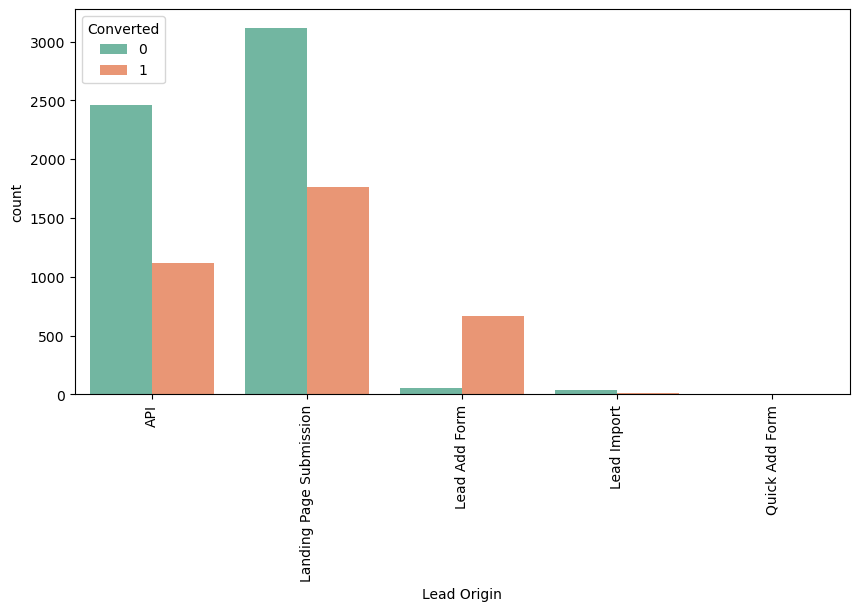

In [1276]:
display_chart_for_categorical_variable(main_dataset, 'Lead Origin')

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
1. Conversion Rate of label through Lead Add Form is high.<br>
2. API and Landing Page Submission conversion is also significant.
</div>

#### 3.5.3.2 Analyzing Variable : Lead Source

In [1277]:
# checking values of Lead Source
main_dataset['Lead Source'].value_counts(dropna = False)

Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
NaN                    36
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: Lead Source, dtype: int64

In [1278]:
# Checking the null values
main_dataset['Lead Source'].isnull().sum()

36

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
1. Since some of the labels are having very less frequency, we can bring them all under a single label "Other Source"<br>
2. The label google is repeated, hence we can merge to a single label.<br>
3. Also, we can assign the null values to the newly created labels.<br>
</div>

In [1279]:
# Converting NULL to Other Source
main_dataset['Lead Source'] = main_dataset['Lead Source'].replace(np.nan, 'Other Source')

# Changing label to Google
main_dataset['Lead Source'] = main_dataset['Lead Source'].replace('google', 'Google')

# Renaming less frequency lables to Other Source
main_dataset['Lead Source'] = main_dataset['Lead Source'].replace(['bing','Click2call', 'Press_Release', 
                                  'Social Media', 'Live Chat', 'youtubechannel', 
                                  'testone', 'Pay per Click Ads', 'welearnblog_Home', 
                                  'WeLearn', 'blog', 'NC_EDM'], 'Other Source')

In [1280]:
# checking values of Lead Source
main_dataset['Lead Source'].value_counts()

Google              2873
Direct Traffic      2543
Olark Chat          1755
Organic Search      1154
Reference            534
Welingak Website     142
Referral Sites       125
Other Source          59
Facebook              55
Name: Lead Source, dtype: int64

In [1281]:
# Checking the null values
main_dataset['Lead Source'].isnull().sum()

0

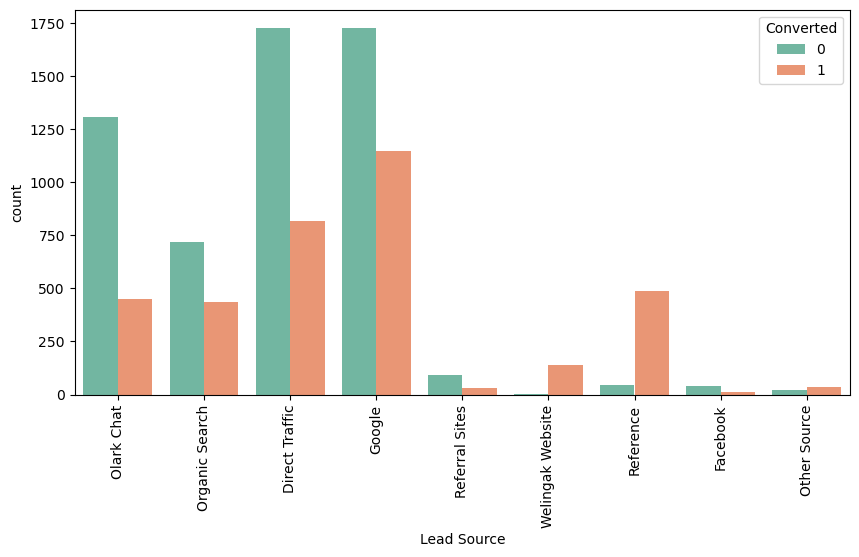

In [1282]:
display_chart_for_categorical_variable(main_dataset, 'Lead Source')

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
1. Maximum number of conversion are generated by Google and Direct traffic.<br>
2. Conversion Rate of reference label and welingak website is high.
</div>

#### 3.5.3.3 Analyzing Variable : Do Not Email

In [1283]:
# checking values of Lead Source
main_dataset['Do Not Email'].value_counts()

No     8506
Yes     734
Name: Do Not Email, dtype: int64

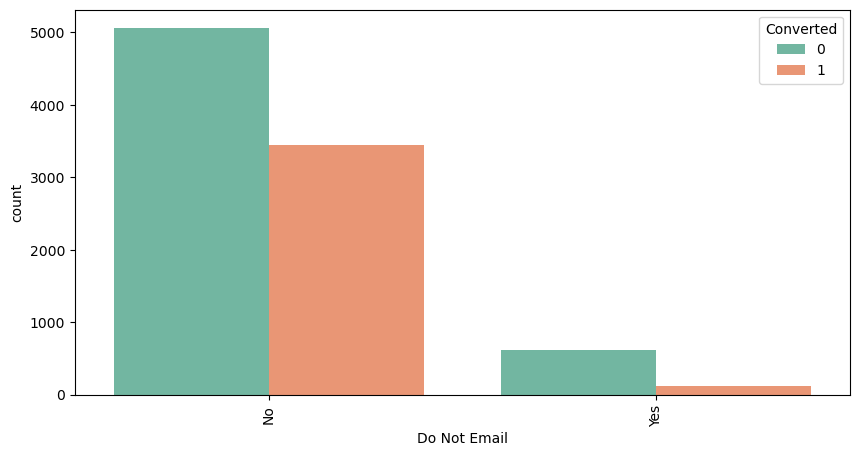

In [1284]:
display_chart_for_categorical_variable(main_dataset, 'Do Not Email')

#### 3.5.3.4 Analyzing Variable : Do Not Call

In [1285]:
# checking values of Lead Source
main_dataset['Do Not Call'].value_counts()

No     9238
Yes       2
Name: Do Not Call, dtype: int64

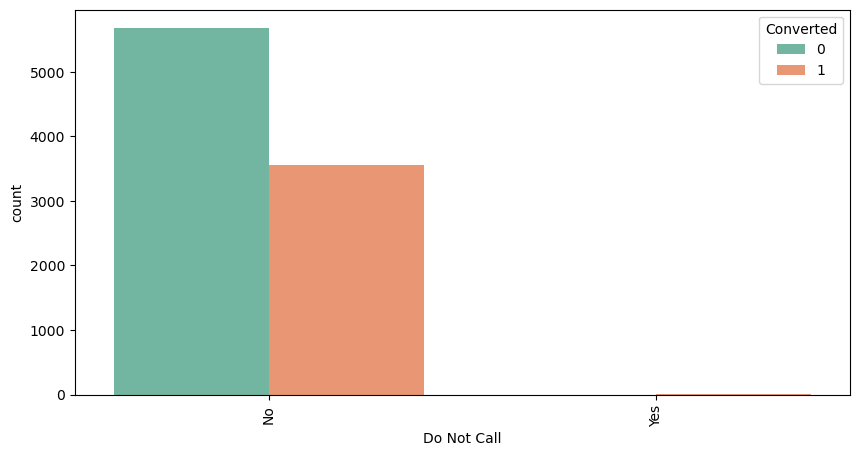

In [1286]:
display_chart_for_categorical_variable(main_dataset, 'Do Not Call')

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
1. Since the value in column Do Not Call is biased, we can drop the column Do Not Call.<br>
</div>

In [1287]:
main_dataset = main_dataset.drop('Do Not Call', axis=1)

In [1288]:
# Verify the column Do Not Call is Dropped
main_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 27 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Origin                                    9240 non-null   object 
 1   Lead Source                                    9240 non-null   object 
 2   Do Not Email                                   9240 non-null   object 
 3   Converted                                      9240 non-null   int64  
 4   TotalVisits                                    9103 non-null   float64
 5   Total Time Spent on Website                    9240 non-null   int64  
 6   Page Views Per Visit                           9103 non-null   float64
 7   Last Activity                                  9137 non-null   object 
 8   Country                                        6779 non-null   object 
 9   Specialization                                 5860 

#### 3.5.3.5 Analyzing Variable : Last Activity

In [1289]:
# checking values of Lead Source
main_dataset['Last Activity'].value_counts()

Email Opened                    3437
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Received                     2
Email Marked Spam                  2
Visited Booth in Tradeshow         1
Resubscribed to emails             1
Name: Last Activity, dtype: int64

In [1290]:
# Checking the null values
main_dataset['Last Activity'].isnull().sum()

103

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
1. Since some of the labels are having very less frequency, we can bring them all under a single label "Others"<br>
2. Also, we can assign the null values to the newly created label.
</div>

In [1291]:
# Converting NULL to Other Source
main_dataset['Last Activity'] = main_dataset['Last Activity'].replace(np.nan, 'Others')

# Renaming less frequency lables to Other Source
main_dataset['Last Activity'] = main_dataset['Last Activity'].replace(['Unreachable','Unsubscribed', 
                                  'Had a Phone Conversation', 
                                  'Approached upfront', 'View in browser link Clicked', 'Email Received', 
                                  'Email Marked Spam', 'Visited Booth in Tradeshow', 'Resubscribed to emails'], 'Others')

In [1292]:
# checking values of Lead Source
main_dataset['Last Activity'].value_counts()

Email Opened                 3437
SMS Sent                     2745
Olark Chat Conversation       973
Page Visited on Website       640
Converted to Lead             428
Email Bounced                 326
Others                        308
Email Link Clicked            267
Form Submitted on Website     116
Name: Last Activity, dtype: int64

In [1293]:
# Checking the null values
main_dataset['Last Activity'].isnull().sum()

0

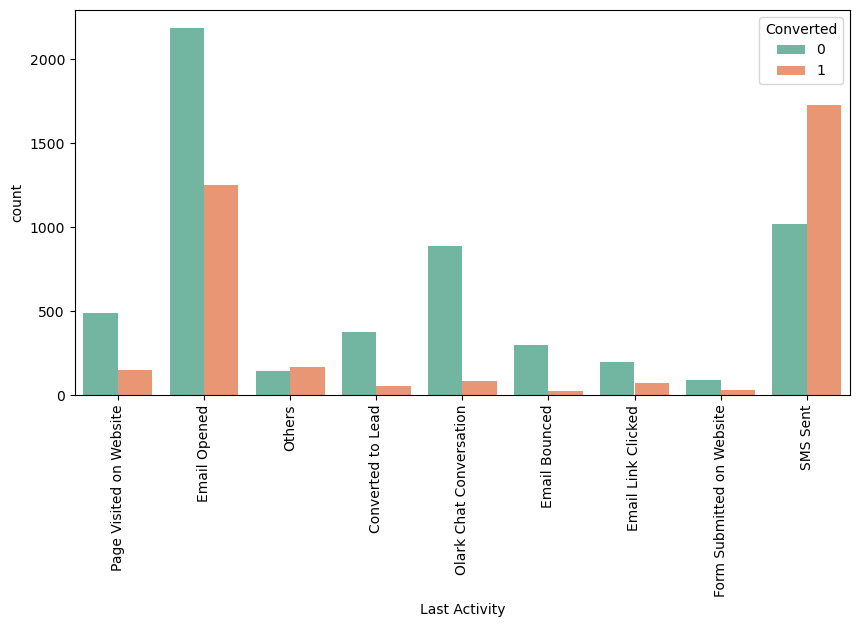

In [1294]:
display_chart_for_categorical_variable(main_dataset, 'Last Activity')

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
1. Maximum number of conversion are generated by SMS Sent.
</div>

#### 3.5.3.6 Analyzing Variable : Country

In [1295]:
# checking values of Country
main_dataset['Country'].value_counts(dropna = False)

India                   6492
NaN                     2461
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Bahrain                    7
Hong Kong                  7
Oman                       6
France                     6
unknown                    5
Kuwait                     4
South Africa               4
Canada                     4
Nigeria                    4
Germany                    4
Sweden                     3
Philippines                2
Uganda                     2
Italy                      2
Bangladesh                 2
Netherlands                2
Asia/Pacific Region        2
China                      2
Belgium                    2
Ghana                      2
Kenya                      1
Sri Lanka                  1
Tanzania                   1
Malaysia                   1
Liberia                    1
Switzerland   

In [1296]:
# Checking the null values
main_dataset['Country'].isnull().sum()

2461

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
    1. We can use Mode to update missing values. Hence we can substitute all missing values with India because it occurs the most frequently among the non-missing values.<br>
    2. Label India occurs 6492 time. After imputing 2461 NULL values with India, the total value for India will become more that 99%. The data will be of no use for modelling. <br>
    3. Hence, we can drop the feature.</b><br>
</div>

In [1297]:
# Dropping column Country
main_dataset = main_dataset.drop('Country', axis=1)

In [1298]:
# Verify Country  coulmn is dropped
main_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 26 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Origin                                    9240 non-null   object 
 1   Lead Source                                    9240 non-null   object 
 2   Do Not Email                                   9240 non-null   object 
 3   Converted                                      9240 non-null   int64  
 4   TotalVisits                                    9103 non-null   float64
 5   Total Time Spent on Website                    9240 non-null   int64  
 6   Page Views Per Visit                           9103 non-null   float64
 7   Last Activity                                  9240 non-null   object 
 8   Specialization                                 5860 non-null   object 
 9   What is your current occupation                6550 

#### 3.5.3.7 Analyzing Variable : Specialization

In [1299]:
# checking values of Lead Source
main_dataset['Specialization'].value_counts()

Finance Management                   976
Human Resource Management            848
Marketing Management                 838
Operations Management                503
Business Administration              403
IT Projects Management               366
Supply Chain Management              349
Banking, Investment And Insurance    338
Travel and Tourism                   203
Media and Advertising                203
International Business               178
Healthcare Management                159
Hospitality Management               114
E-COMMERCE                           112
Retail Management                    100
Rural and Agribusiness                73
E-Business                            57
Services Excellence                   40
Name: Specialization, dtype: int64

In [1300]:
# Checking the null values
main_dataset['Specialization'].isnull().sum()

3380

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
    1. There are 3380 Null values in Specialization variable.<br>
    2. Since the data is spread across all most of the labels, we cannot use median or mode. It is better to create a new category and assign the NULL value to it.<br>
</div>

In [1301]:
# Converting NULL to Other Source
main_dataset['Specialization'] = main_dataset['Specialization'].replace(np.nan, 'Others_Specialization')

In [1302]:
# checking values of Lead Source
main_dataset['Specialization'].value_counts(dropna = False)

Others_Specialization                3380
Finance Management                    976
Human Resource Management             848
Marketing Management                  838
Operations Management                 503
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Travel and Tourism                    203
Media and Advertising                 203
International Business                178
Healthcare Management                 159
Hospitality Management                114
E-COMMERCE                            112
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: Specialization, dtype: int64

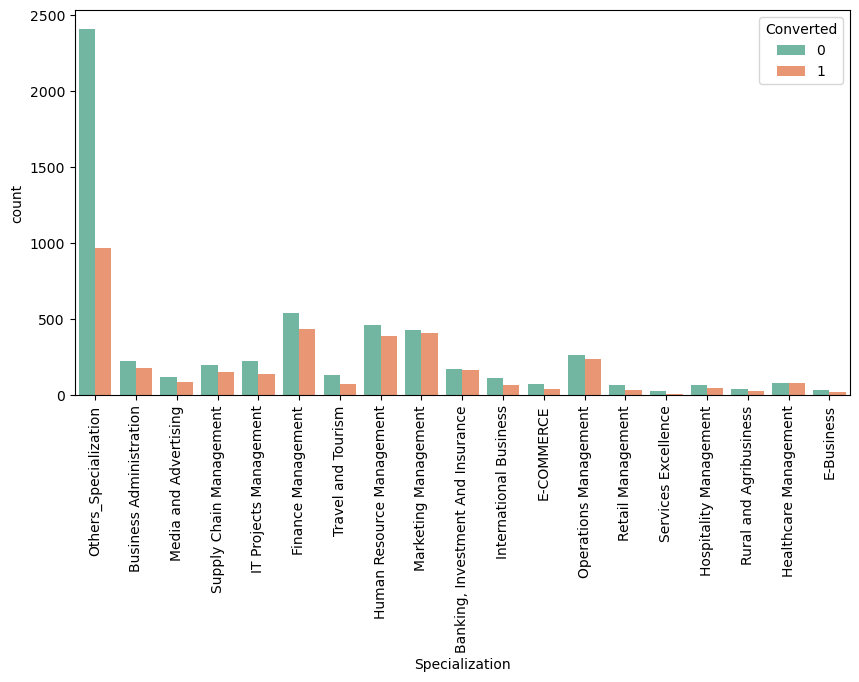

In [1303]:
display_chart_for_categorical_variable(main_dataset, 'Specialization')

#### 3.5.3.8 Analyzing Variable : What is your current occupation

In [1304]:
# checking values of What is your current occupation
main_dataset['What is your current occupation'].value_counts(dropna = False)

Unemployed              5600
NaN                     2690
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
    1. There are 2690 Null values in What is your current occupation variable. <br>
    2. Here we can use Mode to replace the NULL value, i.e use Unemployed.<br>
</div>

In [1305]:
# Converting NULL value to Unemployed
main_dataset['What is your current occupation'] = main_dataset['What is your current occupation'].replace(np.nan, 'Unemployed')

In [1306]:
# checking values of What is your current occupation
main_dataset['What is your current occupation'].value_counts(dropna = False)

Unemployed              8290
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

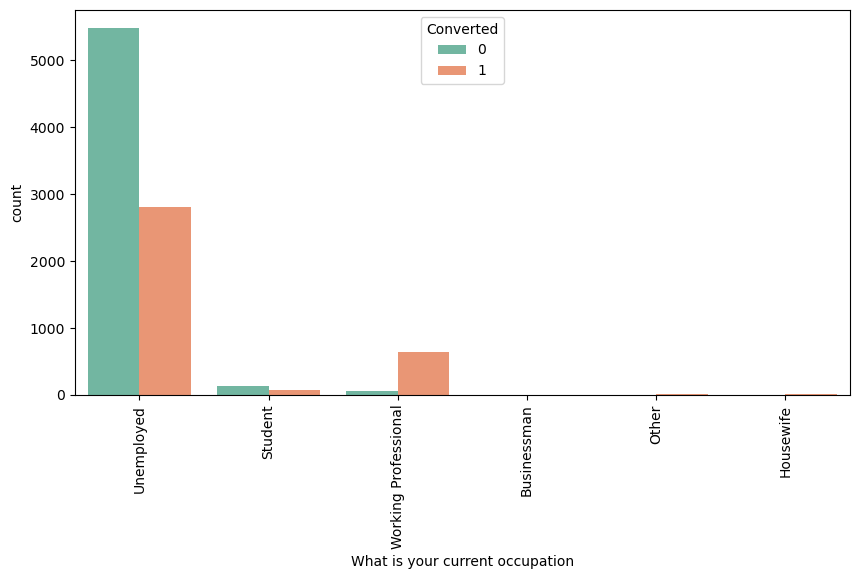

In [1307]:
display_chart_for_categorical_variable(main_dataset, 'What is your current occupation')

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
    1. Working Professionals have high chances of becoming hot leads.
</div>

#### 3.5.3.9 Analyzing Variable : Tags

In [1308]:
# checking values of Tags
main_dataset['Tags'].value_counts(dropna = False)

NaN                                                  3353
Will revert after reading the email                  2072
Ringing                                              1203
Interested in other courses                           513
Already a student                                     465
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          175
Not doing further education                           145
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    27
in touch with 

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
1. Since Null value amounts to the greater part of the data, we will allocate a seperate label say "Unspecified" <br>
2. All low frequency data can be clubbed to Other_Tags label
</div>

In [1309]:
# Converting NULL to Other Source
main_dataset['Tags'] = main_dataset['Tags'].replace(np.nan, 'Unspecified')

# Renaming less frequency lables to Other Source
main_dataset['Tags'] = main_dataset['Tags'].replace(['invalid number', 'Diploma holder (Not Eligible)', 
                                                     'wrong number given', 'opp hangup', 'number not provided',
                                                    'in touch with EINS', 'Lost to Others', 'Still Thinking',
                                                    'In confusion whether part time or DLP', 
                                                    'Interested in Next batch', 
                                                     'Want to take admission but has financial problems',
                                                    'Lateral student', 'Shall take in the next coming month',
                                                    'University not recognized', 'Recognition issue (DEC approval)'], 'Other_Tags')


In [1310]:
# checking values of Tags
main_dataset['Tags'].value_counts(dropna = False)

Unspecified                            3353
Will revert after reading the email    2072
Ringing                                1203
Interested in other courses             513
Already a student                       465
Closed by Horizzon                      358
Other_Tags                              302
switched off                            240
Busy                                    186
Lost to EINS                            175
Not doing further education             145
Interested  in full time MBA            117
Graduation in progress                  111
Name: Tags, dtype: int64

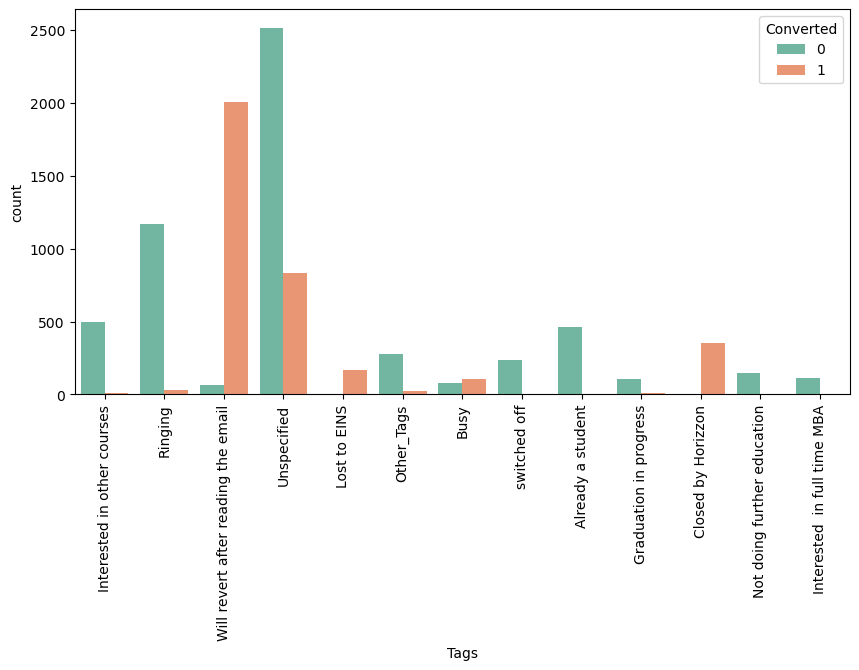

In [1311]:
display_chart_for_categorical_variable(main_dataset, 'Tags')

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
1. We can clearly see that Tags with "Will revert after reading the email" and "Closed by Horizzon" have higher turn in ratio. <br>
</div>

#### 3.5.3.10 Analyzing Variable : City

In [1312]:
# checking values of City
main_dataset['City'].value_counts(dropna = False)

NaN                            3669
Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: City, dtype: int64

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
    1. We can use Mode to update missing values. Hence we can substitute all missing values with Mumbai because it occurs the most frequently among the non-missing values.<br>
</div>

In [1313]:
# Converting NULL to Other Source
main_dataset['City'] = main_dataset['City'].replace(np.nan, 'Mumbai')

In [1314]:
# checking values of City
main_dataset['City'].value_counts(dropna = False)

Mumbai                         6891
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: City, dtype: int64

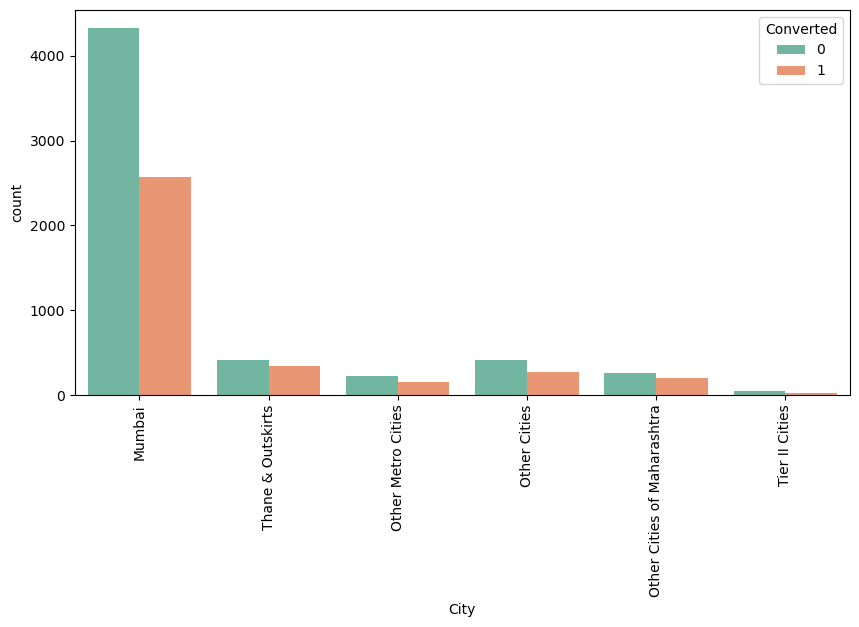

In [1315]:
display_chart_for_categorical_variable(main_dataset, 'City')

#### 3.5.3.11 Analyzing Variable : What matters most to you in choosing a course

In [1316]:
# checking values of What matters most to you in choosing a course
main_dataset['What matters most to you in choosing a course'].value_counts(dropna = False)

Better Career Prospects      6528
NaN                          2709
Flexibility & Convenience       2
Other                           1
Name: What matters most to you in choosing a course, dtype: int64

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
1. Here we can use Mode to replace the NULL value, i.e Better Career Prospects <br>
2. But the data is biased, hence we can drop the variable.
</div>

In [1317]:
main_dataset = main_dataset.drop('What matters most to you in choosing a course', axis=1)

#### 3.5.3.12 Analyzing Variable : Search,<br> Magazine,<br> Newspaper Article,<br> X Education Forums,<br> Newspaper,<br> Digital Advertisement,<br> Through Recommendations,<br> Receive More Updates About Our Courses,<br> Update me on Supply Chain Content,<br> Get updates on DM Content,<br>I agree to pay the amount through cheque

In [1318]:
cols_to_drop = ['Search',
        'Magazine',
        'Newspaper Article',
        'X Education Forums',
        'Newspaper',
        'Digital Advertisement',
        'Through Recommendations',
        'Receive More Updates About Our Courses',
        'Update me on Supply Chain Content',
        'Get updates on DM Content',
        'I agree to pay the amount through cheque']
for feature in cols_to_drop:
    print_value_counts(main_dataset, feature)

Column Name :  Search
No     9226
Yes      14
Name: Search, dtype: int64


Column Name :  Magazine
No    9240
Name: Magazine, dtype: int64


Column Name :  Newspaper Article
No     9238
Yes       2
Name: Newspaper Article, dtype: int64


Column Name :  X Education Forums
No     9239
Yes       1
Name: X Education Forums, dtype: int64


Column Name :  Newspaper
No     9239
Yes       1
Name: Newspaper, dtype: int64


Column Name :  Digital Advertisement
No     9236
Yes       4
Name: Digital Advertisement, dtype: int64


Column Name :  Through Recommendations
No     9233
Yes       7
Name: Through Recommendations, dtype: int64


Column Name :  Receive More Updates About Our Courses
No    9240
Name: Receive More Updates About Our Courses, dtype: int64


Column Name :  Update me on Supply Chain Content
No    9240
Name: Update me on Supply Chain Content, dtype: int64


Column Name :  Get updates on DM Content
No    9240
Name: Get updates on DM Content, dtype: int64


Column Name :  I agree to 

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
1. Here the data is biased, hence we can drop the following variables.<br>
Search <br>
Magazine <br>
Newspaper Article <br>
X Education Forums <br>
Newspaper<br>
Digital Advertisement<br>
Through Recommendations<br>
Receive More Updates About Our Courses<br>
Update me on Supply Chain Content<br>
Get updates on DM Content<br>
I agree to pay the amount through cheque<br>
</div>

In [1319]:
main_dataset = main_dataset.drop(cols_to_drop, axis=1)
main_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9240 non-null   object 
 1   Lead Source                             9240 non-null   object 
 2   Do Not Email                            9240 non-null   object 
 3   Converted                               9240 non-null   int64  
 4   TotalVisits                             9103 non-null   float64
 5   Total Time Spent on Website             9240 non-null   int64  
 6   Page Views Per Visit                    9103 non-null   float64
 7   Last Activity                           9240 non-null   object 
 8   Specialization                          9240 non-null   object 
 9   What is your current occupation         9240 non-null   object 
 10  Tags                                    9240 non-null   obje

### 3.5.4 Analyzing Numerical Variables And Fixing Missing Values

#### 3.5.4.1 Analyzing Numerical variable : TotalVisits

Value count of  TotalVisits
0.0    2189
2.0    1680
3.0    1306
4.0    1120
5.0     783
Name: TotalVisits, dtype: int64
***************************************************************************

Number of records with NULL Value
Number of Null values in TotalVisits :  137
Percentage of Null values in TotalVisits :  1.482684%
***************************************************************************

Describing Feature :  TotalVisits
count    9103.000000
mean        3.445238
std         4.854853
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       251.000000
Name: TotalVisits, dtype: float64
***************************************************************************

Mode and Median of Feature :  TotalVisits
Mode Value :  0.0
Median Value :  3.0
***************************************************************************

Print the Percentile of Feature :  TotalVisits
0.00      0.0
0.10      0.0
0.20      0.0
0.30      2.0
0.40      2.0
0.50   

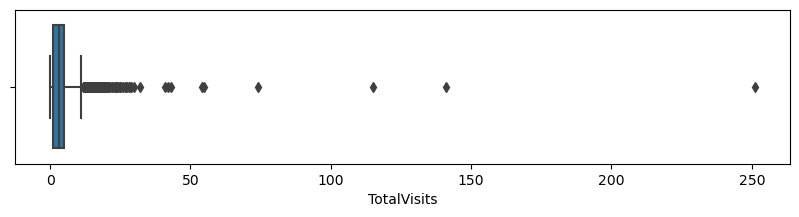

In [1320]:
display_missing_value_analysis(main_dataset, 'TotalVisits', percentile_required = True, boxplot_required = True)

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
1. As we can see, there are outliers in the data, we can impute data above 0.99 perentile and with this the NULL value will also be removed.
</div>

In [1321]:
# Outlier data imputation
main_dataset = main_dataset[main_dataset['TotalVisits'] <= main_dataset['TotalVisits'].quantile(0.99)]

In [1322]:
main_dataset.shape

(9020, 14)

Value count of  TotalVisits
0.0    2189
2.0    1680
3.0    1306
4.0    1120
5.0     783
Name: TotalVisits, dtype: int64
***************************************************************************

Number of records with NULL Value
Number of Null values in TotalVisits :  0
Percentage of Null values in TotalVisits :  0.000000%
***************************************************************************

Describing Feature :  TotalVisits
count    9020.000000
mean        3.206984
std         2.990108
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        17.000000
Name: TotalVisits, dtype: float64
***************************************************************************

Mode and Median of Feature :  TotalVisits
Mode Value :  0.0
Median Value :  3.0
***************************************************************************

Print the Percentile of Feature :  TotalVisits
0.00     0.00
0.10     0.00
0.20     0.00
0.30     2.00
0.40     2.00
0.50     

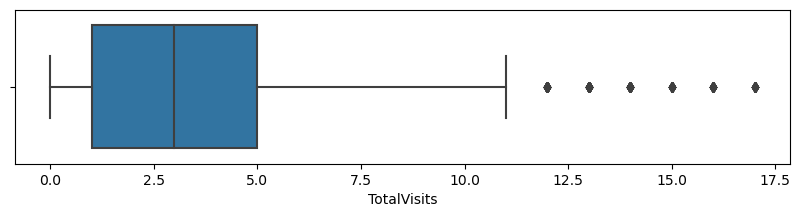

In [1323]:
display_missing_value_analysis(main_dataset, 'TotalVisits', percentile_required = True, boxplot_required = True)

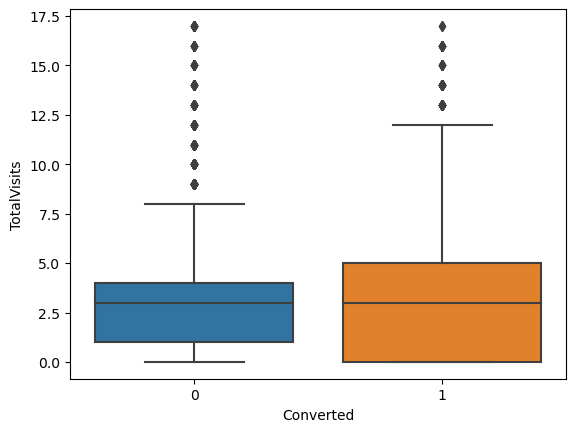

In [1324]:
# Analysis of TotalVisits with Target Variable
sns.boxplot(y = 'TotalVisits', x = 'Converted', data = main_dataset)
plt.show()

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
1. Median of Converted and Not Converted are the pretty close.
</div>

#### 3.5.4.2 Analyzing Numerical variable : Total Time Spent on Website

Value count of  Total Time Spent on Website
0      2193
60       19
75       18
127      18
234      17
Name: Total Time Spent on Website, dtype: int64
***************************************************************************

Number of records with NULL Value
Number of Null values in Total Time Spent on Website :  0
Percentage of Null values in Total Time Spent on Website :  0.000000%
***************************************************************************

Describing Feature :  Total Time Spent on Website
count    9020.000000
mean      479.759534
std       544.688157
min         0.000000
25%         7.000000
50%       243.000000
75%       915.250000
max      2272.000000
Name: Total Time Spent on Website, dtype: float64
***************************************************************************

Mode and Median of Feature :  Total Time Spent on Website
Mode Value :  0
Median Value :  243.0
***************************************************************************

Print the Perc

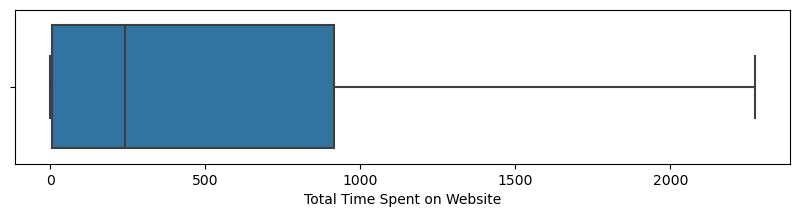

In [1325]:
display_missing_value_analysis(main_dataset, 'Total Time Spent on Website', percentile_required = True, boxplot_required = True)

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
1. There is no outlier in the variable.
</div>

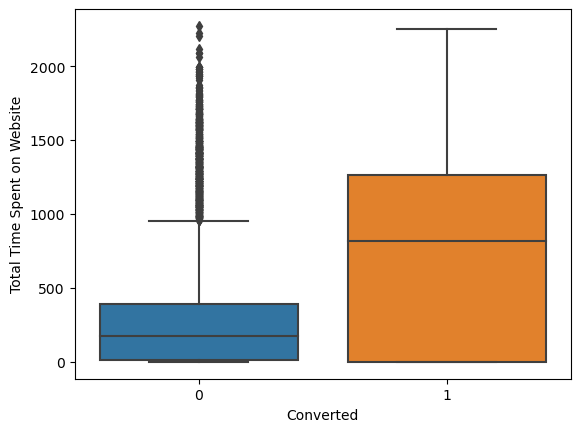

In [1326]:
# Analysis of Total Time Spent on Website with Target Variable
sns.boxplot(y = 'Total Time Spent on Website', x = 'Converted', data = main_dataset)
plt.show()

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
1. People spending more time on the website are more likely to be converted.
</div>

#### 3.5.4.3 Analyzing Numerical variable : Page Views Per Visit

Value count of  Page Views Per Visit
0.0    2189
2.0    1792
3.0    1193
4.0     893
1.0     651
Name: Page Views Per Visit, dtype: int64
***************************************************************************

Number of records with NULL Value
Number of Null values in Page Views Per Visit :  0
Percentage of Null values in Page Views Per Visit :  0.000000%
***************************************************************************

Describing Feature :  Page Views Per Visit
count    9020.000000
mean        2.337271
std         2.062363
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        16.000000
Name: Page Views Per Visit, dtype: float64
***************************************************************************

Mode and Median of Feature :  Page Views Per Visit
Mode Value :  0.0
Median Value :  2.0
***************************************************************************

Print the Percentile of Feature :  Page Views Per Visit
0.00   

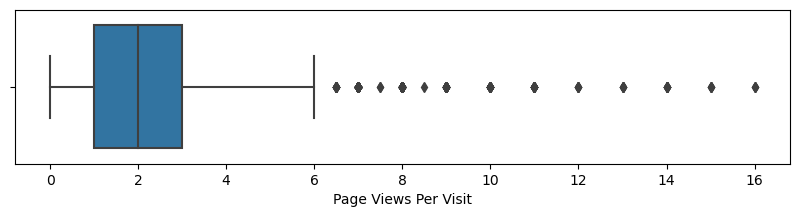

In [1327]:
display_missing_value_analysis(main_dataset, 'Page Views Per Visit', percentile_required = True, boxplot_required = True)

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
1. Eventhough there is a outlier, it is usual for a person to scan to all the pages of the website, before making any purchase. So lets not consider imputing the data.
</div>

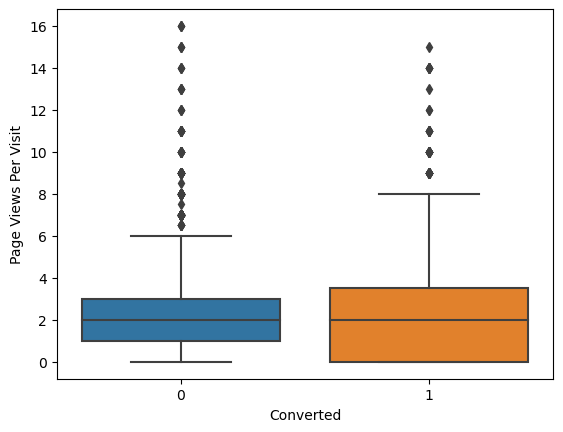

In [1328]:
# Analysis of Page Views Per Visit with Target Variable
sns.boxplot(y = 'Page Views Per Visit', x = 'Converted', data = main_dataset)
plt.show()

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
1. Median of Converted and Not Converted are the pretty close.
</div>

In [1329]:
main_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9020 entries, 0 to 9239
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9020 non-null   object 
 1   Lead Source                             9020 non-null   object 
 2   Do Not Email                            9020 non-null   object 
 3   Converted                               9020 non-null   int64  
 4   TotalVisits                             9020 non-null   float64
 5   Total Time Spent on Website             9020 non-null   int64  
 6   Page Views Per Visit                    9020 non-null   float64
 7   Last Activity                           9020 non-null   object 
 8   Specialization                          9020 non-null   object 
 9   What is your current occupation         9020 non-null   object 
 10  Tags                                    9020 non-null   obje

#### Checking correlations of numeric variables

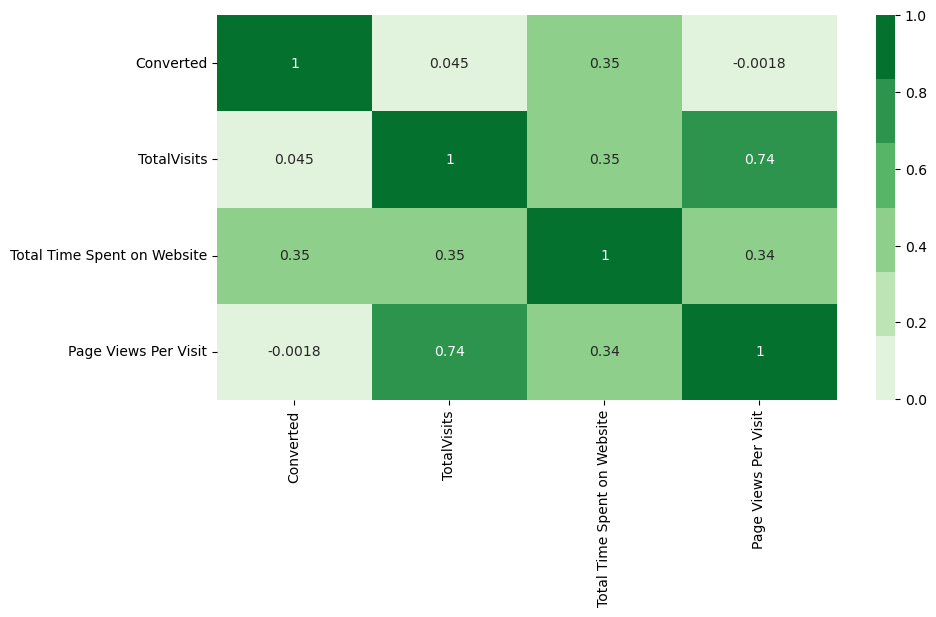

In [1330]:
# figure size
plt.figure(figsize=(10,5))

# heatmap
# creating a colormap
colormap = sns.color_palette("Greens")

sns.heatmap(main_dataset.corr(), cmap = colormap, annot=True)
plt.show()

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
1. There is definitely a correlation between the variables.
</div>

In [1331]:
main_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9020 entries, 0 to 9239
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9020 non-null   object 
 1   Lead Source                             9020 non-null   object 
 2   Do Not Email                            9020 non-null   object 
 3   Converted                               9020 non-null   int64  
 4   TotalVisits                             9020 non-null   float64
 5   Total Time Spent on Website             9020 non-null   int64  
 6   Page Views Per Visit                    9020 non-null   float64
 7   Last Activity                           9020 non-null   object 
 8   Specialization                          9020 non-null   object 
 9   What is your current occupation         9020 non-null   object 
 10  Tags                                    9020 non-null   obje

# 4. Data Preparation

## 4.1 Converting some binary variables (Yes/No) to 0/1

In [1332]:
# List of variables to map

map_list =  ['Do Not Email', 'A free copy of Mastering The Interview']

# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function to the main dataset
main_dataset[map_list] = main_dataset[map_list].apply(binary_map)

In [1333]:
main_dataset.head()

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,Tags,City,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,0,0,0.0,0,0.0,Page Visited on Website,Others_Specialization,Unemployed,Interested in other courses,Mumbai,0,Modified
1,API,Organic Search,0,0,5.0,674,2.5,Email Opened,Others_Specialization,Unemployed,Ringing,Mumbai,0,Email Opened
2,Landing Page Submission,Direct Traffic,0,1,2.0,1532,2.0,Email Opened,Business Administration,Student,Will revert after reading the email,Mumbai,1,Email Opened
3,Landing Page Submission,Direct Traffic,0,0,1.0,305,1.0,Others,Media and Advertising,Unemployed,Ringing,Mumbai,0,Modified
4,Landing Page Submission,Google,0,1,2.0,1428,1.0,Converted to Lead,Others_Specialization,Unemployed,Will revert after reading the email,Mumbai,0,Modified


## 4.2 Creating dummy variables

In [1334]:
# Creating dummy variables for the variable 'Lead Origin'
lo_df = pd.get_dummies(main_dataset['Lead Origin'], prefix = 'LeadOrigin')
# Dropping LeadOrigin_Landing Page Submission column
lo_final = lo_df.drop(['LeadOrigin_Landing Page Submission'], 1)
#Adding the results to the master dataframe
main_dataset = pd.concat([main_dataset, lo_final], axis = 1)

# Creating dummy variables for the variable 'Lead Source'
ls_df = pd.get_dummies(main_dataset['Lead Source'], prefix = 'LeadSource')
# Dropping LeadSource_Other Source column
ls_final = ls_df.drop(['LeadSource_Other Source'], 1)
#Adding the results to the master dataframe
main_dataset = pd.concat([main_dataset, ls_final], axis = 1)

# Creating dummy variables for the variable 'Last Activity'
la_df = pd.get_dummies(main_dataset['Last Activity'], prefix = 'LastActivity')
# Dropping LastActivity_Form Submitted on Website column
la_final = la_df.drop(['LastActivity_Form Submitted on Website'], 1)
#Adding the results to the master dataframe
main_dataset = pd.concat([main_dataset, la_final], axis = 1)

# Creating dummy variables for the variable 'Specialization'
sp_df = pd.get_dummies(main_dataset['Specialization'], prefix = 'Specialization')
# Dropping Specialization_Banking, Investment And Insurance column
sp_final = sp_df.drop(['Specialization_Banking, Investment And Insurance'], 1)
#Adding the results to the master dataframe
main_dataset = pd.concat([main_dataset, sp_final], axis = 1)

# Creating dummy variables for the variable 'What is your current occupation'
co_df = pd.get_dummies(main_dataset['What is your current occupation'], prefix = 'CurrentOccupation')
# Dropping CurrentOccupation_Working Professional
co_final = co_df.drop(['CurrentOccupation_Other'], 1)
#Adding the results to the master dataframe
main_dataset = pd.concat([main_dataset, co_final], axis = 1)

# Creating dummy variables for the variable 'Tags'
t_df = pd.get_dummies(main_dataset['Tags'], prefix = 'Tags')
# Dropping Tags_Will revert after reading the email
t_final = t_df.drop(['Tags_Will revert after reading the email'], 1)
#Adding the results to the master dataframe
main_dataset = pd.concat([main_dataset, t_final], axis = 1)

# Creating dummy variables for the variable 'City'
c_df = pd.get_dummies(main_dataset['City'], prefix = 'City')
# Dropping City_Other Cities of Maharashtra
c_final = c_df.drop(['City_Other Cities of Maharashtra'], 1)
#Adding the results to the master dataframe
main_dataset = pd.concat([main_dataset, c_final], axis = 1)

# Creating dummy variables for the variable 'Last Notable Activity'
na_df = pd.get_dummies(main_dataset['Last Notable Activity'], prefix = 'LastNotableActivity')
# Dropping LastNotableActivity_View in browser link Clicked
na_final = na_df.drop(['LastNotableActivity_View in browser link Clicked'], 1)
#Adding the results to the master dataframe
main_dataset = pd.concat([main_dataset, na_final], axis = 1)

In [1335]:
# We have created dummies for the below variables, so we can drop them
main_dataset = main_dataset.drop(['Lead Origin','Lead Source', 'Last Activity', 'Specialization', 'What is your current occupation',
                       'Tags', 'City', 'Last Notable Activity'], 1)

In [1336]:
main_dataset.head()

,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,LeadOrigin_API,LeadOrigin_Lead Add Form,LeadOrigin_Lead Import,LeadSource_Direct Traffic,LeadSource_Facebook,LeadSource_Google,LeadSource_Olark Chat,LeadSource_Organic Search,LeadSource_Reference,LeadSource_Referral Sites,LeadSource_Welingak Website,LastActivity_Converted to Lead,LastActivity_Email Bounced,LastActivity_Email Link Clicked,LastActivity_Email Opened,LastActivity_Olark Chat Conversation,LastActivity_Others,LastActivity_Page Visited on Website,LastActivity_SMS Sent,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others_Specialization,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,CurrentOccupation_Businessman,CurrentOccupation_Housewife,CurrentOccupation_Student,CurrentOccupation_Unemployed,CurrentOccupation_Working Professional,Tags_Already a student,Tags_Busy,Tags_Closed by Horizzon,Tags_Graduation in progress,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Other_Tags,Tags_Ringing,Tags_Unspecified,Tags_switched off,City_Mumbai,City_Other Cities,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,LastNotableActivity_Approached upfront,LastNotableActivity_Email Bounced,LastNotableActivity_Email Link Clicked,LastNotableActivity_Email Marked Spam,LastNotableActivity_Email Opened,LastNotableActivity_Email Received,LastNotableActivity_Form Submitted on Website,LastNotableActivity_Had a Phone Conversation,LastNotableActivity_Modified,LastNotableActivity_Olark Chat Conversation,LastNotableActivity_Page Visited on Website,LastNotableActivity_Resubscribed to emails,LastNotableActivity_SMS Sent,LastNotableActivity_Unreachable,LastNotableActivity_Unsubscribed
0,0,0,0.0,0,0.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,5.0,674,2.5,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,1,2.0,1532,2.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,1.0,305,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,1,2.0,1428,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [1337]:
main_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9020 entries, 0 to 9239
Data columns (total 80 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Do Not Email                                   9020 non-null   int64  
 1   Converted                                      9020 non-null   int64  
 2   TotalVisits                                    9020 non-null   float64
 3   Total Time Spent on Website                    9020 non-null   int64  
 4   Page Views Per Visit                           9020 non-null   float64
 5   A free copy of Mastering The Interview         9020 non-null   int64  
 6   LeadOrigin_API                                 9020 non-null   uint8  
 7   LeadOrigin_Lead Add Form                       9020 non-null   uint8  
 8   LeadOrigin_Lead Import                         9020 non-null   uint8  
 9   LeadSource_Direct Traffic                      9020 

# 5. Test-Train Split

In [1338]:
# Putting feature variable to X
X = main_dataset.drop(['Converted'], axis=1)
X.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,LeadOrigin_API,LeadOrigin_Lead Add Form,LeadOrigin_Lead Import,LeadSource_Direct Traffic,LeadSource_Facebook,LeadSource_Google,LeadSource_Olark Chat,LeadSource_Organic Search,LeadSource_Reference,LeadSource_Referral Sites,LeadSource_Welingak Website,LastActivity_Converted to Lead,LastActivity_Email Bounced,LastActivity_Email Link Clicked,LastActivity_Email Opened,LastActivity_Olark Chat Conversation,LastActivity_Others,LastActivity_Page Visited on Website,LastActivity_SMS Sent,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others_Specialization,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,CurrentOccupation_Businessman,CurrentOccupation_Housewife,CurrentOccupation_Student,CurrentOccupation_Unemployed,CurrentOccupation_Working Professional,Tags_Already a student,Tags_Busy,Tags_Closed by Horizzon,Tags_Graduation in progress,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Other_Tags,Tags_Ringing,Tags_Unspecified,Tags_switched off,City_Mumbai,City_Other Cities,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,LastNotableActivity_Approached upfront,LastNotableActivity_Email Bounced,LastNotableActivity_Email Link Clicked,LastNotableActivity_Email Marked Spam,LastNotableActivity_Email Opened,LastNotableActivity_Email Received,LastNotableActivity_Form Submitted on Website,LastNotableActivity_Had a Phone Conversation,LastNotableActivity_Modified,LastNotableActivity_Olark Chat Conversation,LastNotableActivity_Page Visited on Website,LastNotableActivity_Resubscribed to emails,LastNotableActivity_SMS Sent,LastNotableActivity_Unreachable,LastNotableActivity_Unsubscribed
0,0,0.0,0,0.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,5.0,674,2.5,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,2.0,1532,2.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,1.0,305,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,2.0,1428,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [1339]:
# Putting response variable to y
y = main_dataset['Converted']
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

In [1340]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

# 6. Feature Scaling & Checking Correlations

In [1341]:
scaler = StandardScaler()
X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.fit_transform(X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])
X_train.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,LeadOrigin_API,LeadOrigin_Lead Add Form,LeadOrigin_Lead Import,LeadSource_Direct Traffic,LeadSource_Facebook,LeadSource_Google,LeadSource_Olark Chat,LeadSource_Organic Search,LeadSource_Reference,LeadSource_Referral Sites,LeadSource_Welingak Website,LastActivity_Converted to Lead,LastActivity_Email Bounced,LastActivity_Email Link Clicked,LastActivity_Email Opened,LastActivity_Olark Chat Conversation,LastActivity_Others,LastActivity_Page Visited on Website,LastActivity_SMS Sent,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others_Specialization,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,CurrentOccupation_Businessman,CurrentOccupation_Housewife,CurrentOccupation_Student,CurrentOccupation_Unemployed,CurrentOccupation_Working Professional,Tags_Already a student,Tags_Busy,Tags_Closed by Horizzon,Tags_Graduation in progress,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Other_Tags,Tags_Ringing,Tags_Unspecified,Tags_switched off,City_Mumbai,City_Other Cities,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,LastNotableActivity_Approached upfront,LastNotableActivity_Email Bounced,LastNotableActivity_Email Link Clicked,LastNotableActivity_Email Marked Spam,LastNotableActivity_Email Opened,LastNotableActivity_Email Received,LastNotableActivity_Form Submitted on Website,LastNotableActivity_Had a Phone Conversation,LastNotableActivity_Modified,LastNotableActivity_Olark Chat Conversation,LastNotableActivity_Page Visited on Website,LastNotableActivity_Resubscribed to emails,LastNotableActivity_SMS Sent,LastNotableActivity_Unreachable,LastNotableActivity_Unsubscribed
2873,0,0.271781,0.031598,0.814423,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6823,0,1.276480,2.389158,2.274024,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7258,0,-1.067817,-0.874028,-1.131710,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8327,0,1.611379,1.982176,0.167334,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5940,1,-0.732918,-0.701703,-0.645177,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


## Looking at Correlations

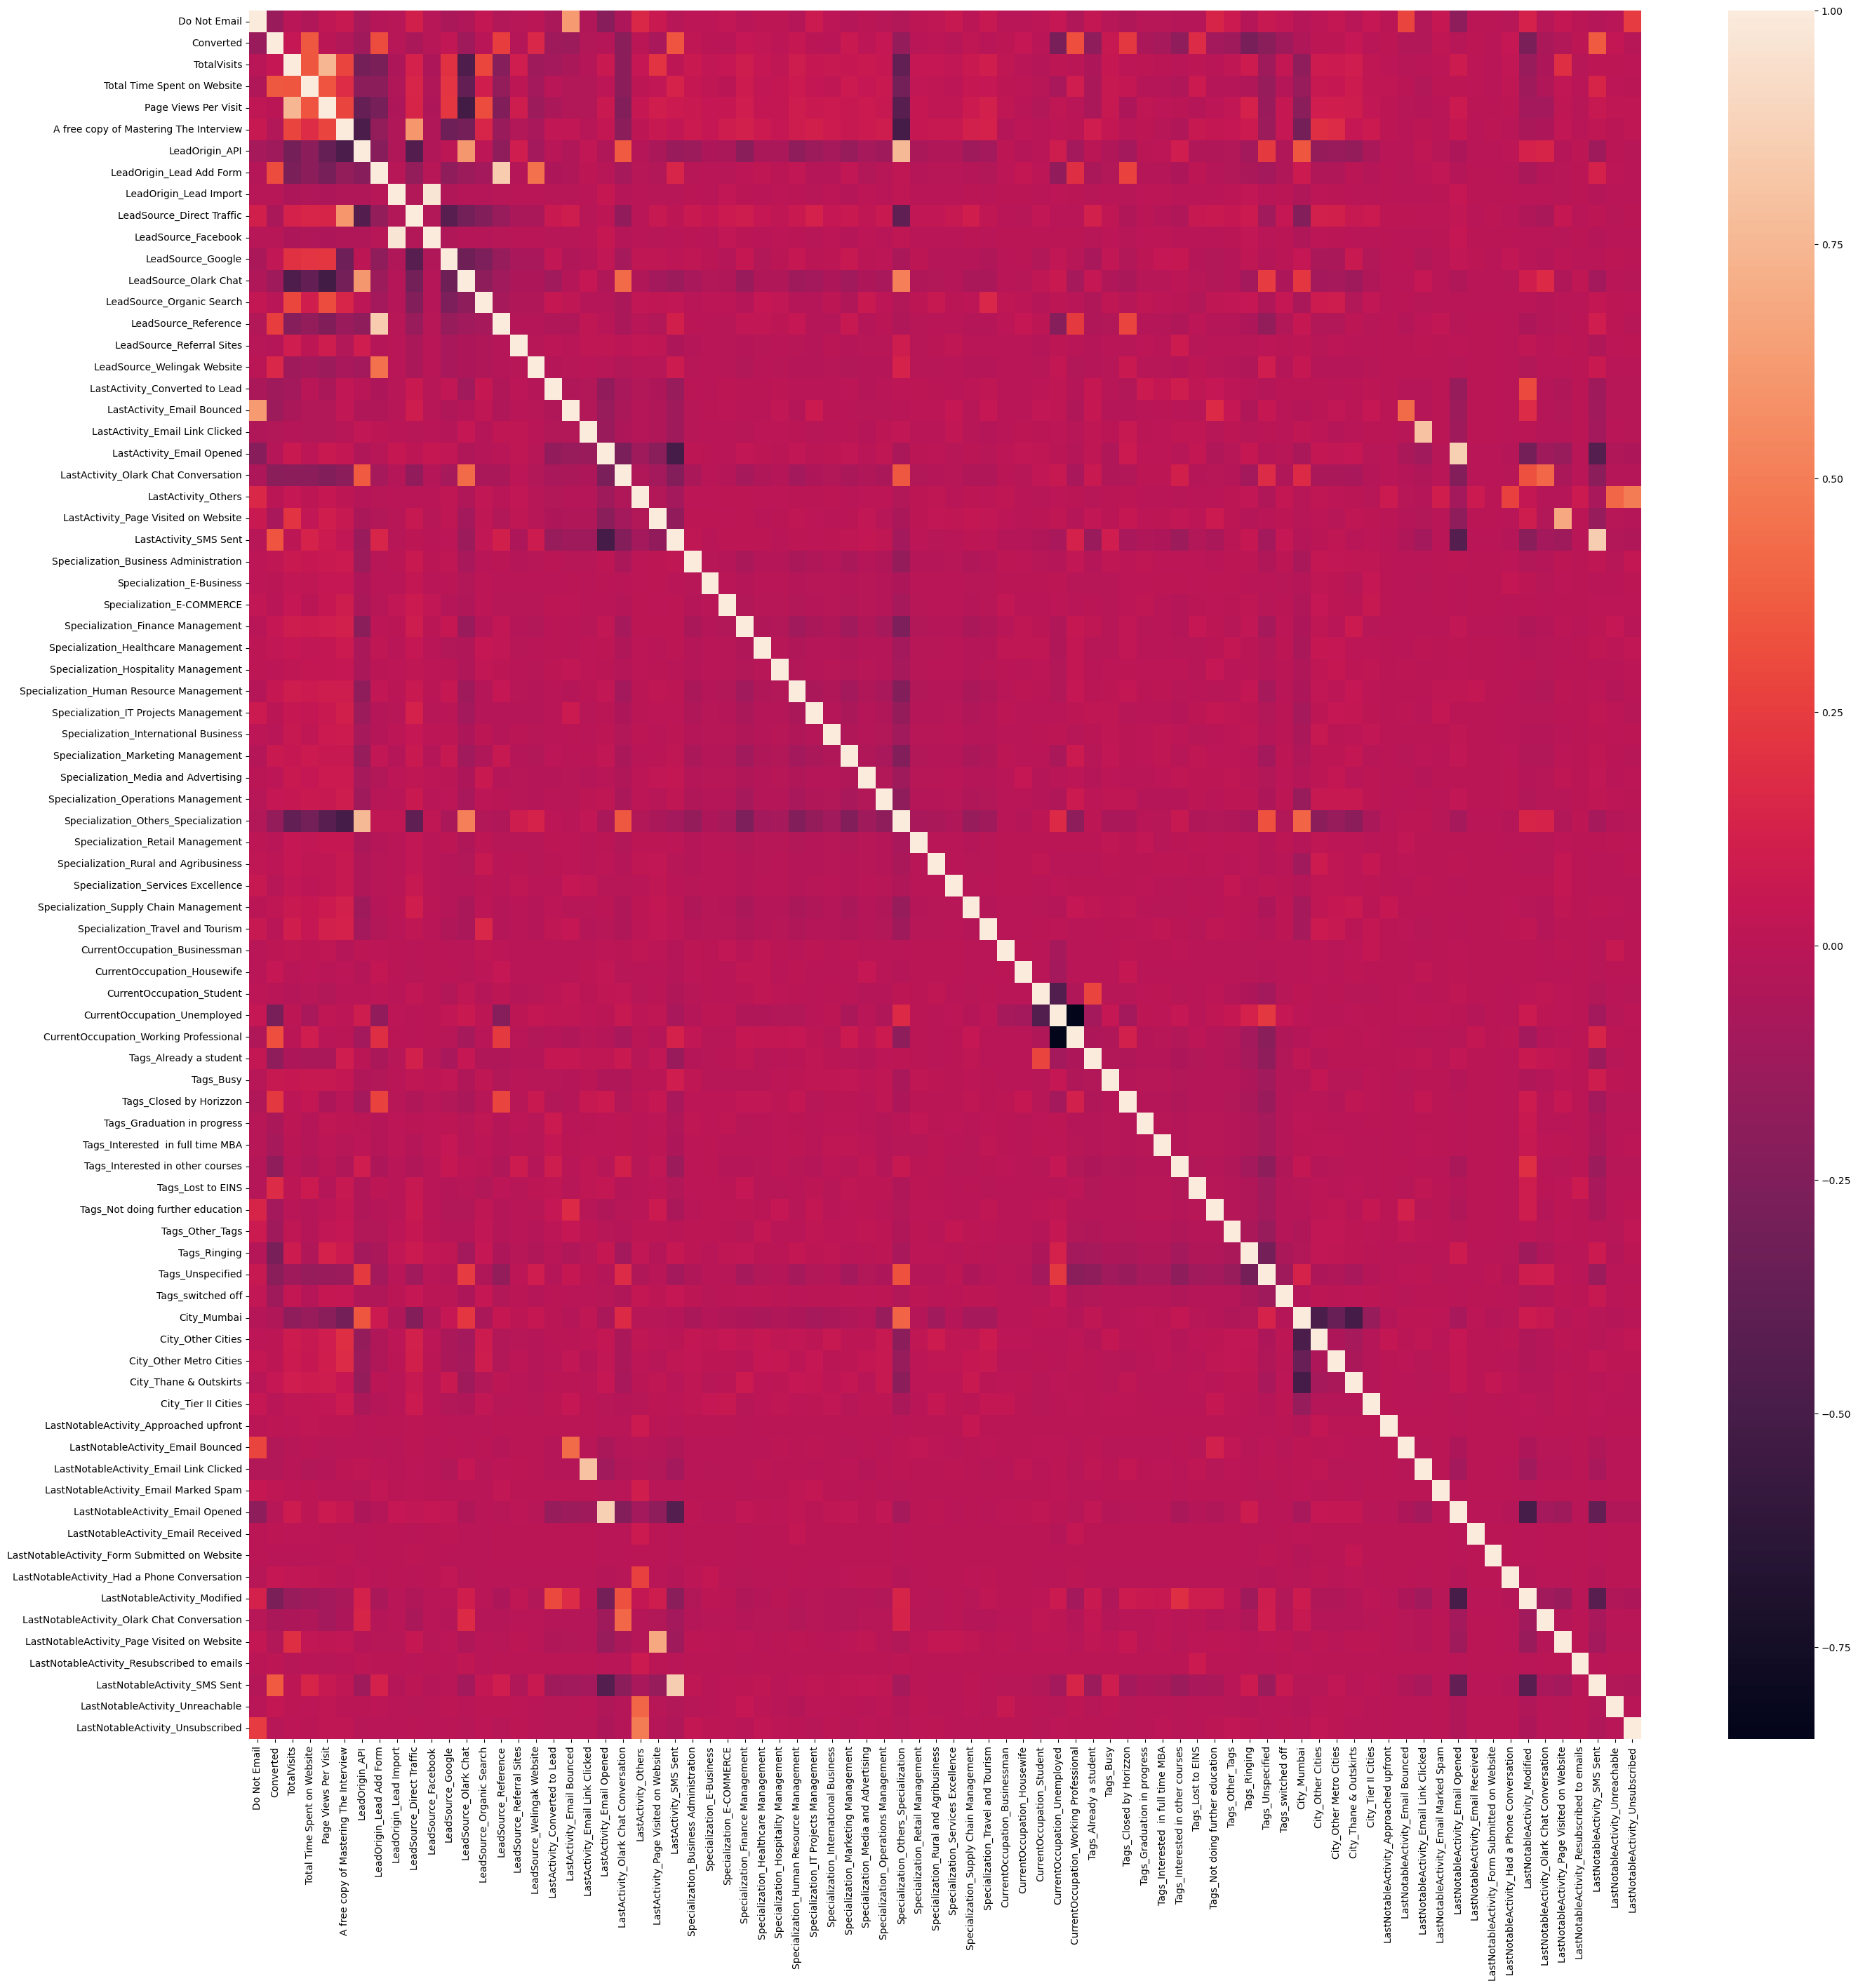

In [1407]:
# Let's see the correlation matrix 
plt.figure(figsize = (32,32))        # Size of the figure
sns.heatmap(main_dataset.corr())
plt.show()

# 7. Model Building

## 7.1 Running Training Model : 01

In [1343]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6314
Model:                            GLM   Df Residuals:                     6237
Model Family:                Binomial   Df Model:                           76
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1159.8
Date:                Sun, 19 Mar 2023   Deviance:                       2319.5
Time:                        13:55:42   Pearson chi2:                 1.11e+04
No. Iterations:                    21   Pseudo R-squ. (CS):             0.6161
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                           -14.1079   4.82e+04     -0.000      1.000   -9.45e+04    9.44e+04
Do Not Email                                     -0.8851      0.324     -2.732      0.006      -1.520      -0.250
TotalVisits                                       0.2753      0.083      3.312      0.001       0.112       0.438
Total Time Spent on Website                       1.1092      0.065     17.062      0.000       0.982       1.237
Page Views Per Visit                             -0.1697      0.091     -1.860      0.063      -0.349       0.009
A free copy of Mastering The Interview           -0.1537      0.186     -0.825      0.409      -0.519       0.211
LeadOrigin_API                                    0.4756      0.241      1.973      0.048       0.003       0.948
LeadOrigin_Lead Add Form                          2.8860      1.222      2.362      0.018       0.491       5.281
LeadOrigin_Lead Import                            2.9600      1.675      1.767      0.077      -0.323       6.243
LeadSource_Direct Traffic                        -1.1565      0.820     -1.410      0.159      -2.764       0.451
LeadSource_Facebook                              -3.3556      1.679     -1.998      0.046      -6.647      -0.064
LeadSource_Google                                -0.9852      0.809     -1.218      0.223      -2.571       0.600
LeadSource_Olark Chat                             0.1432      0.825      0.174      0.862      -1.474       1.760
LeadSource_Organic Search                        -1.0498      0.824     -1.275      0.202      -2.664       0.565
LeadSource_Reference                             -2.0617      1.134     -1.817      0.069      -4.285       0.162
LeadSource_Referral Sites                        -0.8353      0.933     -0.895      0.371      -2.664       0.993
LeadSource_Welingak Website                       2.0129      1.276      1.577      0.115      -0.488       4.514
LastActivity_Converted to Lead                   -0.7251      0.641     -1.132      0.258      -1.980       0.530
LastActivity_Email Bounced                       -1.4357      0.970     -1.481      0.139      -3.336       0.465
LastActivity_Email Link Clicked                  -0.5254      0.863     -0.609      0.543      -2.217       1.166
LastActivity_Email Opened                        -0.1635      0.589     -0.278      0.781      -1.318       0.991
LastActivity_Olark Chat Conversation             -1.0654      0.590     -1.806      0.071      -2.222       0.091
LastActivity_Others                               0.5251      0.906      0.580      0.562      -1.250       2.301
LastActivity_Page Visited on Website             -0.4618      0.649     -0.711      0.477      -1.734       0.811
LastA

<div class="alert alert-block alert-success">
1. As we can clearly see that many of the features have high p-value, implying that that variable is statistically insignificant. So we need to eliminate some of the variables in order to build a better model.<br><br>
2. We'll first eliminate a few features using Recursive Feature Elimination (RFE), and once we have reached a small set of variables to work with, we can then use manual feature elimination.
</div>

## 7.2 Feature Selection Using RFE

In [1344]:
logreg = LogisticRegression()

rfe = RFE(logreg, n_features_to_select = 20)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)

In [1345]:
rfe.support_

array([False, False,  True, False, False, False,  True, False,  True,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False])

In [1346]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Do Not Email', False, 5),
 ('TotalVisits', False, 35),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', False, 36),
 ('A free copy of Mastering The Interview', False, 37),
 ('LeadOrigin_API', False, 17),
 ('LeadOrigin_Lead Add Form', True, 1),
 ('LeadOrigin_Lead Import', False, 22),
 ('LeadSource_Direct Traffic', True, 1),
 ('LeadSource_Facebook', False, 20),
 ('LeadSource_Google', False, 3),
 ('LeadSource_Olark Chat', False, 23),
 ('LeadSource_Organic Search', False, 2),
 ('LeadSource_Reference', False, 6),
 ('LeadSource_Referral Sites', False, 8),
 ('LeadSource_Welingak Website', True, 1),
 ('LastActivity_Converted to Lead', False, 16),
 ('LastActivity_Email Bounced', False, 12),
 ('LastActivity_Email Link Clicked', False, 25),
 ('LastActivity_Email Opened', False, 52),
 ('LastActivity_Olark Chat Conversation', False, 10),
 ('LastActivity_Others', False, 11),
 ('LastActivity_Page Visited on Website', False, 34),
 ('LastActivity_SMS Sent', True, 1),
 ('Specializ

In [1347]:
col = X_train.columns[rfe.support_]
col

Index(['Total Time Spent on Website', 'LeadOrigin_Lead Add Form',
       'LeadSource_Direct Traffic', 'LeadSource_Welingak Website',
       'LastActivity_SMS Sent', 'CurrentOccupation_Working Professional',
       'Tags_Already a student', 'Tags_Busy', 'Tags_Closed by Horizzon',
       'Tags_Graduation in progress', 'Tags_Interested  in full time MBA',
       'Tags_Interested in other courses', 'Tags_Lost to EINS',
       'Tags_Not doing further education', 'Tags_Other_Tags', 'Tags_Ringing',
       'Tags_Unspecified', 'Tags_switched off', 'LastNotableActivity_Modified',
       'LastNotableActivity_Olark Chat Conversation'],
      dtype='object')

In [1348]:
X_train.columns[~rfe.support_]

Index(['Do Not Email', 'TotalVisits', 'Page Views Per Visit',
       'A free copy of Mastering The Interview', 'LeadOrigin_API',
       'LeadOrigin_Lead Import', 'LeadSource_Facebook', 'LeadSource_Google',
       'LeadSource_Olark Chat', 'LeadSource_Organic Search',
       'LeadSource_Reference', 'LeadSource_Referral Sites',
       'LastActivity_Converted to Lead', 'LastActivity_Email Bounced',
       'LastActivity_Email Link Clicked', 'LastActivity_Email Opened',
       'LastActivity_Olark Chat Conversation', 'LastActivity_Others',
       'LastActivity_Page Visited on Website',
       'Specialization_Business Administration', 'Specialization_E-Business',
       'Specialization_E-COMMERCE', 'Specialization_Finance Management',
       'Specialization_Healthcare Management',
       'Specialization_Hospitality Management',
       'Specialization_Human Resource Management',
       'Specialization_IT Projects Management',
       'Specialization_International Business',
       'Specializatio

## 7.3 Running Training Model : 02

### 7.3.1 Running Logistic regression model

In [1349]:
# Logistic regression model
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6314
Model:                            GLM   Df Residuals:                     6293
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1235.9
Date:                Sun, 19 Mar 2023   Deviance:                       2471.8
Time:                        13:55:46   Pearson chi2:                 9.49e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.6067
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                           3.1689      0.191     16.560      0.000       2.794       3.544
Total Time Spent on Website                     0.8813      0.053     16.605      0.000       0.777       0.985
LeadOrigin_Lead Add Form                        1.4086      0.419      3.365      0.001       0.588       2.229
LeadSource_Direct Traffic                      -0.7298      0.128     -5.693      0.000      -0.981      -0.479
LeadSource_Welingak Website                     3.4640      0.843      4.109      0.000       1.812       5.116
LastActivity_SMS Sent                           1.9819      0.117     16.986      0.000       1.753       2.211
CurrentOccupation_Working Professional          1.0414      0.392      2.657      0.008       0.273       1.809
Tags_Already a student                         -8.2249      1.024     -8.033      0.000     -10.232      -6.218
Tags_Busy                                      -3.5842      0.295    -12.138      0.000      -4.163      -3.005
Tags_Closed by Horizzon                         2.9228      1.028      2.843      0.004       0.908       4.938
Tags_Graduation in progress                    -4.7612      0.494     -9.635      0.000      -5.730      -3.793
Tags_Interested  in full time MBA              -6.1528      0.664     -9.268      0.000      -7.454      -4.852
Tags_Interested in other courses               -6.2404      0.414    -15.080      0.000      -7.051      -5.429
Tags_Lost to EINS                               1.8156      0.624      2.910      0.004       0.593       3.039
Tags_Not doing further education               -7.1058      1.036     -6.860      0.000      -9.136      -5.076
Tags_Other_Tags                                -6.1048      0.340    -17.959      0.000      -6.771      -5.439
Tags_Ringing                                   -7.7501      0.303    -25.580      0.000      -8.344      -7.156
Tags_Unspecified                               -4.3275      0.193    -22.459      0.000      -4.705      -3.950
Tags_switched off                              -8.2998      0.633    -13.104      0.000      -9.541      -7.058
LastNotableActivity_Modified                   -1.7831      0.127    -14.007      0.000      -2.033      -1.534
LastNotableActivity_Olark Chat Conversation    -1.2117      0.404     -3.003      0.003      -2.003      -0.421
===============================================================================================================
"""

### 7.3.2 Check for the VIF values of the feature variables.

In [1350]:
 # Create a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
18,LastNotableActivity_Modified,1.83
1,LeadOrigin_Lead Add Form,1.67
16,Tags_Unspecified,1.64
2,LeadSource_Direct Traffic,1.46
4,LastActivity_SMS Sent,1.46
3,LeadSource_Welingak Website,1.34
15,Tags_Ringing,1.21
8,Tags_Closed by Horizzon,1.20
0,Total Time Spent on Website,1.19
11,Tags_Interested in other courses,1.18


### 7.3.3 Getting the predicted values on the train dataset

In [1351]:
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

2873    0.999224
6823    0.999295
7258    0.023846
8327    0.975968
5940    0.013520
5686    0.998870
5372    0.999735
4736    0.056839
5812    0.997498
893     0.038749
dtype: float64

In [1352]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.99922427, 0.99929481, 0.02384582, 0.97596796, 0.01352045,
       0.99887017, 0.99973471, 0.05683871, 0.99749836, 0.03874862])

### 7.3.4 Preparing final dataset for analysis

In [1353]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_prob':y_train_pred})
y_train_pred_final['Prospect ID'] = y_train.index
y_train_pred_final.head()

,Converted,Converted_prob,Prospect ID
0,1,0.999224,2873
1,1,0.999295,6823
2,0,0.023846,7258
3,1,0.975968,8327
4,0,0.013520,5940


In [1354]:
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['Predicted'] = y_train_pred_final.Converted_prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Converted,Converted_prob,Prospect ID,Predicted
0,1,0.999224,2873,1
1,1,0.999295,6823,1
2,0,0.023846,7258,0
3,1,0.975968,8327,1
4,0,0.013520,5940,0


### 7.3.5 Preparing Confusion matrix

In [1355]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
print(confusion)

[[3747  190]
 [ 264 2113]]


In [1356]:
# Actual/Predicted          not_converted    converted
        # not_converted        3754             183
        # converted            270              2107  

In [1357]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Predicted)

0.9280962939499525

In [1358]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [1359]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP + FN)

0.8889356331510307

In [1360]:
# Let us calculate specificity
TN / float(TN + FP)

0.951739903479807

In [1361]:
# Calculate False Postive Rate - predicting conversion when customer does not have convert
print(FP / float(TN + FP))

0.048260096520193044


In [1362]:
# positive predictive value 
print (TP / float(TP + FP))

0.9174989144594008


In [1363]:
# Negative predictive value
print (TN / float(TN + FN))

0.9341810022438295


### 7.3.6 Plotting the ROC Curve

<div class="alert alert-block alert-info"> 
An ROC curve demonstrates several things:<br><br>

1. It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).<br>
2. The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.<br>
3. The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.<br>
</div>

In [1364]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, 
                                         y_train_pred_final.Converted_prob, 
                                         drop_intermediate = False )

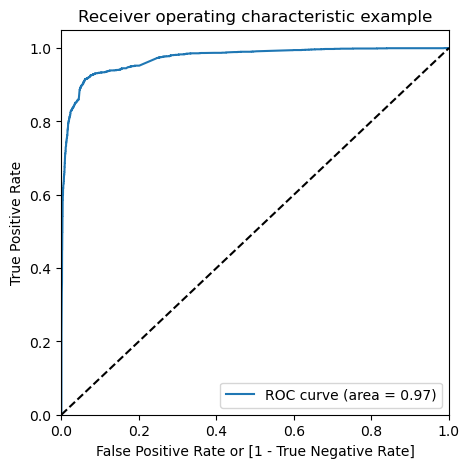

In [1365]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_prob)

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
We are getting a good ROC Curve value of 0.97 indicating a good predictive model.
</div>

### 7.3.7 Finding Optimal Cutoff Point

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
Earlier we have used some random number 0.5 as a cut-off point, now we will find the optimal cut-off point through carefull analysis. Optimal cutoff probability is that prob where we get balanced sensitivity and specificity
</div>

In [1366]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_prob.map(lambda x: 1 if x > i else 0)
    
y_train_pred_final.head()

,Converted,Converted_prob,Prospect ID,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.999224,2873,1,1,1,1,1,1,1,1,1,1,1
1,1,0.999295,6823,1,1,1,1,1,1,1,1,1,1,1
2,0,0.023846,7258,0,1,0,0,0,0,0,0,0,0,0
3,1,0.975968,8327,1,1,1,1,1,1,1,1,1,1,1
4,0,0.013520,5940,0,1,0,0,0,0,0,0,0,0,0


In [1367]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.376465  1.000000  0.000000
0.1   0.1  0.822616  0.977282  0.729235
0.2   0.2  0.907824  0.933950  0.892050
0.3   0.3  0.926196  0.920909  0.929388
0.4   0.4  0.928888  0.904922  0.943358
0.5   0.5  0.928096  0.888936  0.951740
0.6   0.6  0.920019  0.838452  0.969266
0.7   0.7  0.915109  0.807741  0.979934
0.8   0.8  0.906557  0.778292  0.983998
0.9   0.9  0.887551  0.718553  0.989586


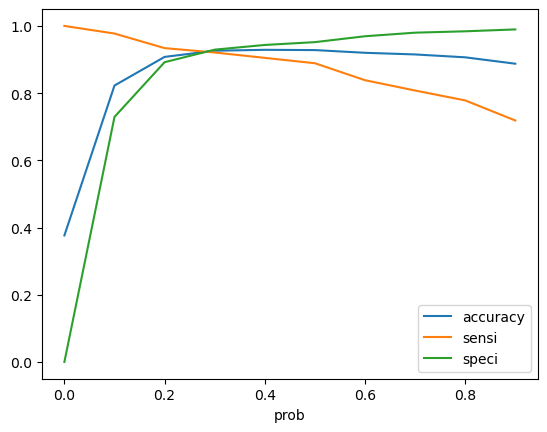

In [1368]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
From the curve above, 0.3 is the optimum point to take it as a cutoff probability.
</div>


In [1369]:
y_train_pred_final['final_Predicted'] = y_train_pred_final.Converted_prob.map( lambda x: 1 if x > 0.3 else 0)

y_train_pred_final.head()

,Converted,Converted_prob,Prospect ID,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_Predicted
0,1,0.999224,2873,1,1,1,1,1,1,1,1,1,1,1,1
1,1,0.999295,6823,1,1,1,1,1,1,1,1,1,1,1,1
2,0,0.023846,7258,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0.975968,8327,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0.013520,5940,0,1,0,0,0,0,0,0,0,0,0,0


### 7.3.8 Creating Column : Lead Score

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
Now lets create a coulmn Lead Score between 0 and 100 to each of the leads which can be used by the company to target potential leads. A higher score would mean that the lead is hot, i.e. is most likely to convert whereas a lower score would mean that the lead is cold and will mostly not get converted.
</div>

In [1370]:
y_train_pred_final['Lead Score'] = y_train_pred_final.Converted_prob.map( lambda x: round(x*100))

y_train_pred_final[['Converted','Converted_prob','Prospect ID','final_Predicted','Lead Score']].head()

,Converted,Converted_prob,Prospect ID,final_Predicted,Lead Score
0,1,0.999224,2873,1,100
1,1,0.999295,6823,1,100
2,0,0.023846,7258,0,2
3,1,0.975968,8327,1,98
4,0,0.013520,5940,0,1


In [1371]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_Predicted)

0.9261957554640482

In [1372]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_Predicted )
confusion2

array([[3659,  278],
       [ 188, 2189]], dtype=int64)

In [1373]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [1374]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.920908708456037

In [1375]:
# Let us calculate specificity
TN / float(TN+FP)

0.9293878587757175

In [1376]:
# Calculate false postive rate - predicting convert when customer does not have convert
print(FP/ float(TN+FP))

0.07061214122428244


In [1377]:
# Positive predictive value 
print (TP / float(TP+FP))

0.8873125253344143


In [1378]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9511307512347283


### 7.3.9 Precision and Recall

In [1379]:
#Looking at the confusion matrix again
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_Predicted )
confusion

array([[3659,  278],
       [ 188, 2189]], dtype=int64)

In [1380]:
##### Precision
# TP / TP + FP
confusion[1,1] / (confusion[0,1] + confusion[1,1])

0.8873125253344143

In [1381]:
##### Recall
# TP / TP + FN
confusion[1,1] / (confusion[1,0] + confusion[1,1])

0.920908708456037

In [1382]:
# Finding the precision score
precision_score(y_train_pred_final.Converted , y_train_pred_final.final_Predicted)

0.8873125253344143

In [1383]:
# Finding the recall score
recall_score(y_train_pred_final.Converted, y_train_pred_final.final_Predicted)

0.920908708456037

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
Following are the observation after running the model on the Train DataSet <br>

<b>Accuracy : 92.61% </b><br>
<b>Sensitivity : 92.09% </b><br>
<b>Specificity : 92.93% </b><br>
<b>Precision Score : 88.73% </b><br>
<b>Recall Score : 92.09% <br>
</div>

###  7.3.10 Precision and recall tradeoff

In [1384]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_prob)

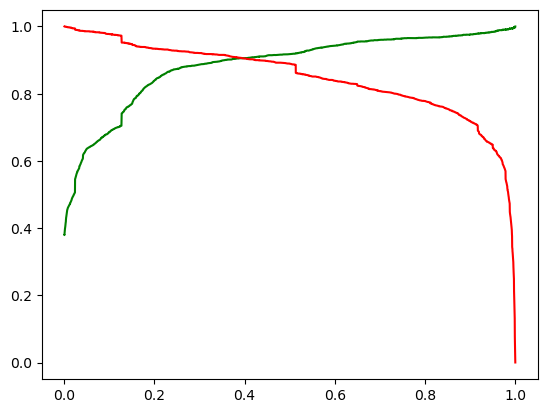

In [1385]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

# 8. Making predictions on the test dataset

## 8.1 Feature Scaling on test dataset

In [1386]:
# Sclaing the numerical variables. Here we use only Transform.
X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.transform(X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])
X_test.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,LeadOrigin_API,LeadOrigin_Lead Add Form,LeadOrigin_Lead Import,LeadSource_Direct Traffic,LeadSource_Facebook,LeadSource_Google,LeadSource_Olark Chat,LeadSource_Organic Search,LeadSource_Reference,LeadSource_Referral Sites,LeadSource_Welingak Website,LastActivity_Converted to Lead,LastActivity_Email Bounced,LastActivity_Email Link Clicked,LastActivity_Email Opened,LastActivity_Olark Chat Conversation,LastActivity_Others,LastActivity_Page Visited on Website,LastActivity_SMS Sent,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others_Specialization,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,CurrentOccupation_Businessman,CurrentOccupation_Housewife,CurrentOccupation_Student,CurrentOccupation_Unemployed,CurrentOccupation_Working Professional,Tags_Already a student,Tags_Busy,Tags_Closed by Horizzon,Tags_Graduation in progress,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Other_Tags,Tags_Ringing,Tags_Unspecified,Tags_switched off,City_Mumbai,City_Other Cities,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,LastNotableActivity_Approached upfront,LastNotableActivity_Email Bounced,LastNotableActivity_Email Link Clicked,LastNotableActivity_Email Marked Spam,LastNotableActivity_Email Opened,LastNotableActivity_Email Received,LastNotableActivity_Form Submitted on Website,LastNotableActivity_Had a Phone Conversation,LastNotableActivity_Modified,LastNotableActivity_Olark Chat Conversation,LastNotableActivity_Page Visited on Website,LastNotableActivity_Resubscribed to emails,LastNotableActivity_SMS Sent,LastNotableActivity_Unreachable,LastNotableActivity_Unsubscribed
5130,1,-1.067817,-0.874028,-1.131710,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6929,0,0.606681,-0.820864,1.300957,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1484,1,0.271781,-0.644872,0.814423,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6519,0,-0.398018,2.024341,-0.158643,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
7472,0,-0.398018,1.666857,-0.158643,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [1387]:
X_test = X_test[col]
X_test.head()

,Total Time Spent on Website,LeadOrigin_Lead Add Form,LeadSource_Direct Traffic,LeadSource_Welingak Website,LastActivity_SMS Sent,CurrentOccupation_Working Professional,Tags_Already a student,Tags_Busy,Tags_Closed by Horizzon,Tags_Graduation in progress,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Other_Tags,Tags_Ringing,Tags_Unspecified,Tags_switched off,LastNotableActivity_Modified,LastNotableActivity_Olark Chat Conversation
5130,-0.874028,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
6929,-0.820864,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1484,-0.644872,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
6519,2.024341,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7472,1.666857,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1388]:
X_test_sm = sm.add_constant(X_test)

## 8.2 Making predictions on the test dataset

In [1389]:
y_test_pred = res.predict(X_test_sm)

In [1390]:
y_test_pred[:10]

5130    0.023846
6929    0.132153
1484    0.007028
6519    0.306768
7472    0.997241
7920    0.087830
3962    0.041461
6135    0.023846
8701    0.934683
5461    0.997977
dtype: float64

In [1391]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.head()

,0
5130,0.023846
6929,0.132153
1484,0.007028
6519,0.306768
7472,0.997241


In [1392]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

# Putting CustID to index
y_test_df['Prospect ID'] = y_test_df.index

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Converted_prob'})

# Rearranging the columns
y_pred_final = y_pred_final[['Prospect ID','Converted','Converted_prob']]

# Adding Lead Score to the DF
y_pred_final['Lead Score'] = y_pred_final.Converted_prob.map( lambda x: round(x*100))

y_pred_final.head()

,Prospect ID,Converted,Converted_prob,Lead Score
0,5130,0,0.023846,2
1,6929,0,0.132153,13
2,1484,0,0.007028,1
3,6519,0,0.306768,31
4,7472,1,0.997241,100


In [1393]:
y_pred_final['final_Predicted'] = y_pred_final.Converted_prob.map(lambda x: 1 if x > 0.3 else 0)
y_pred_final.head(5)

,Prospect ID,Converted,Converted_prob,Lead Score,final_Predicted
0,5130,0,0.023846,2,0
1,6929,0,0.132153,13,0
2,1484,0,0.007028,1,0
3,6519,0,0.306768,31,1
4,7472,1,0.997241,100,1


In [1394]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_Predicted)

0.9238728750923872

## 8.3 Creating Confusion Matrix, checking precision and recall

In [1395]:
confusion2 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_Predicted )
confusion2

array([[1531,  127],
       [  79,  969]], dtype=int64)

In [1396]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [1397]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.924618320610687

In [1398]:
# Let us calculate specificity
TN / float(TN+FP)

0.9234016887816646

In [1399]:
precision_score(y_pred_final.Converted , y_pred_final.final_Predicted)

0.8841240875912408

In [1400]:
recall_score(y_pred_final.Converted, y_pred_final.final_Predicted)

0.924618320610687

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
Following are the observation after running the model on the Test DataSet <br>

<b>Accuracy : 92.42% </b><br>
<b>Sensitivity : 92.55% </b><br>
<b>Specificity : 92.34% </b><br>
<b>Precision Score : 88.42% </b><br>
<b>Recall Score : 92.55% <br>
</div>

<div class="alert alert-block alert-success"> 
So, we have succeeded in achieving our objective of estimating the target lead conversion rate to be about 90%. <br>
The model appears to be accurate in anticipating the conversion rates, thus we should be able to provide the management the confidence to make decisions based on this model, in order to achieve a higher lead conversion rate of more than 90%.
</div>

## 8.4 Important Features in our Final Model

In [1401]:
res.params.sort_values(ascending=False)

LeadSource_Welingak Website                    3.464012
const                                          3.168851
Tags_Closed by Horizzon                        2.922821
LastActivity_SMS Sent                          1.981879
Tags_Lost to EINS                              1.815583
LeadOrigin_Lead Add Form                       1.408620
CurrentOccupation_Working Professional         1.041405
Total Time Spent on Website                    0.881318
LeadSource_Direct Traffic                     -0.729801
LastNotableActivity_Olark Chat Conversation   -1.211737
LastNotableActivity_Modified                  -1.783098
Tags_Busy                                     -3.584180
Tags_Unspecified                              -4.327468
Tags_Graduation in progress                   -4.761242
Tags_Other_Tags                               -6.104794
Tags_Interested  in full time MBA             -6.152762
Tags_Interested in other courses              -6.240418
Tags_Not doing further education              -7

# 9. Conclusion

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
Following are the observation after running the model on the Train DataSet <br>

<b>Accuracy : 92.58% </b><br>
<b>Sensitivity : 92.17% </b><br>
<b>Specificity : 92.83% </b><br>
<b>Precision Score : 88.59% </b><br>
<b>Recall Score : 92.17% <br>
</div>

<div class="alert alert-block alert-success">
    <b>Observarions : </b><br><br>
Following are the observation after running the model on the Test DataSet <br>

<b>Accuracy : 92.42% </b><br>
<b>Sensitivity : 92.55% </b><br>
<b>Specificity : 92.34% </b><br>
<b>Precision Score : 88.42% </b><br>
<b>Recall Score : 92.55% <br>
</div>

<div class="alert alert-block alert-success">
    <b>Recommendations : </b><br><br>
Following are the Recommendations to the management <br>

1. The business <b>should call the leads</b> obtained from the <b>Lead Source "Welingak Websites"</b> as they are more likely to convert.<br>
2. The business <b>should call the leads</b> obtained from the <b>Last Activity was "SMS Sent"</b> as they are more likely to convert.<br>
3. The business <b>should call the leads</b> marked with <b>Tags "Closed by Horizzon" and "Lost to EINS"</b> as they are more likely to convert.<br>
4. The business <b>should call the leads</b> obtained from the <b>Lead Origin "Lead Add Form"</b> as they are more likely to convert.<br>
5. The business <b>should call the leads</b> obtained whose is <b>"Working Professionals"</b> as they are more likely to convert.<br>
6. The business <b>should call the leads</b> who <b>spent more time on the website</b> as they are more likely to convert.<br>

7. The business <b>should not make calls</b> to the leads whose <b>lead source is "Direct Traffic"</b> as they are not likely to get converted.<br>
8. The business <b>should not make calls</b> to the leads whose <b>last activity was "Olark Chat Conversation"</b> and "Modified" as they are not likely to get converted.<br>
9. The business <b>should not make calls</b> to the leads whose <b>lead source is "Direct Traffic"</b> as they are not likely to get converted.<br>
10. The business <b>should not make calls</b> to the leads whose <b>tag is "Busy", "Unspecified", "Graduation in progress", "Interested  in full time MBA", "Interested in other courses", "Not doing further education", "Ringing", "Already a student", "switched off"</b> as they are not likely to get converted.

</div>